In [32]:
import matplotlib.pyplot as plt

class PlotStyle:
    def __init__(self, xlabel='', ylabel='', title='', legend_title='', cmap='viridis', fig_size=(8, 6)):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title
        self.legend_title = legend_title
        self.cmap = cmap
        self.fig_size = fig_size

    def apply_labels(self, ax):
        if self.xlabel:
            ax.set_xlabel(self.xlabel)
        if self.ylabel:
            ax.set_ylabel(self.ylabel)
        if self.title:
            ax.set_title(self.title)


def scatter_with_hue(df, x_col, y_col, hue_col, style: PlotStyle = None):
    cmap = style.cmap if style else 'viridis'
    fig_size = style.fig_size if style else (8, 6)

    fig, ax = plt.subplots(figsize=fig_size)
    scatter = ax.scatter(
        df[x_col], df[y_col],
        c=df[hue_col],
        cmap=cmap,
        edgecolor='k',
        alpha=0.7
    )

    if style:
        style.apply_labels(ax)
        legend_label = style.legend_title or hue_col
    else:
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f'{y_col} vs {x_col}')
        legend_label = hue_col

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(legend_label)
    plt.tight_layout()
    plt.show()


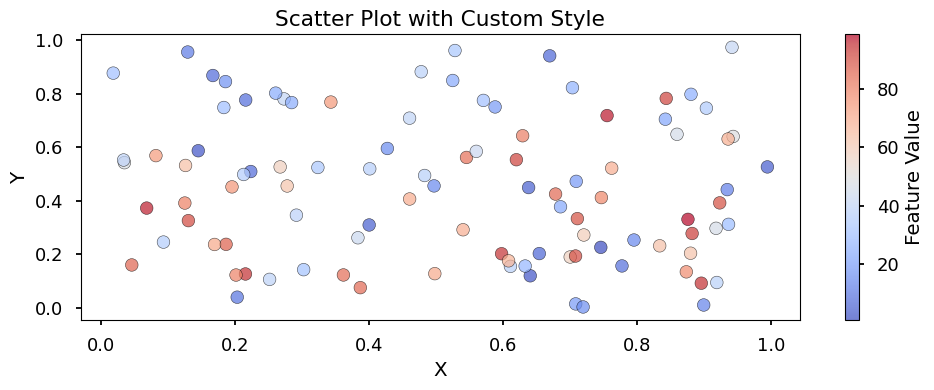

In [35]:
import pandas as pd
import numpy as np

# Example DataFrame
df = pd.DataFrame({
    'x': np.random.rand(100),
    'y': np.random.rand(100),
    'feature': np.random.rand(100) * 100
})

style = PlotStyle(
    xlabel='X',
    ylabel='Y',
    title='Scatter Plot with Custom Style',
    legend_title='Feature Value',
    cmap='coolwarm',
    fig_size=(10, 4)
)

with plt.style.context('seaborn-v0_8-talk'):
    scatter_with_hue(df, 'x', 'y', 'feature', style=style)


In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def scatter_with_time_hue(df, x_col, y_col, time_col, cmap='viridis'):
    # Convert time column to datetime if needed
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Use timestamps as color values
    time_numeric = df[time_col].map(pd.Timestamp.toordinal)

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        df[x_col], df[y_col],
        c=time_numeric,
        cmap=cmap,
        edgecolor='k',
        alpha=0.8,
    )

    # Apply labels
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{y_col} vs {x_col} (colored by {time_col})')

    # Add colorbar with formatted dates
    cbar = plt.colorbar(sc, ax=ax)
    tick_locs = cbar.get_ticks()
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([pd.Timestamp.fromordinal(int(t)).date() for t in tick_locs])
    # cbar.set_ticklabels([pd.Timestamp.fromordinal(int(t)).strftime('%y/%m/%d') for t in tick_locs])

    cbar.set_label(time_col)
    plt.tight_layout()
    plt.show()


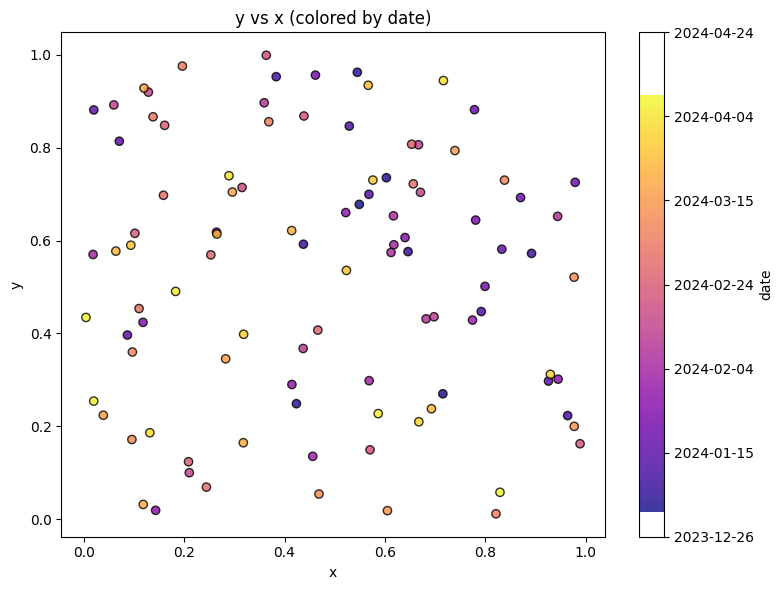

In [72]:
import pandas as pd
import numpy as np

# Fake data
np.random.seed(0)
df = pd.DataFrame({
    'x': np.random.rand(100),
    'y': np.random.rand(100),
    'date': pd.date_range('2024-01-01', periods=100)
})

scatter_with_time_hue(df, 'x', 'y', 'date', cmap='plasma')


In [78]:
def assign_category_tiers(df, group_col, value_col, method="kmeans", n_tiers=4, weight_col=None):
    """
    Assign categories into tiers based on aggregated value_col using clustering or quantile methods.

    Parameters:
    - df: DataFrame containing the data
    - group_col: Column to group by (e.g., 'category')
    - value_col: Numeric column to aggregate (e.g., 'value')
    - method: 'kmeans' or 'quantile'
    - n_tiers: Number of tiers
    - weight_col: Optional column for weighted aggregation

    Returns:
    - DataFrame with [group_col, 'tier'] indicating assigned tiers
    """
    if weight_col:
        agg_df = df.groupby(group_col).apply(
            lambda g: np.average(g[value_col], weights=g[weight_col])
        ).reset_index(name="avg_value")
    else:
        agg_df = df.groupby(group_col)[value_col].mean().reset_index(name="avg_value")

    if method == "kmeans":
        km = KMeans(n_clusters=n_tiers, random_state=42)
        agg_df["tier"] = km.fit_predict(agg_df[["avg_value"]])
    elif method == "quantile":
        agg_df["tier"] = pd.qcut(agg_df["avg_value"], q=n_tiers, labels=False) + 1
    else:
        raise ValueError("Only 'kmeans' and 'quantile' methods are supported.")

    # Normalize tier labels so that tier 1 is the tightest/lowest avg_value
    tier_order = agg_df.groupby("tier")["avg_value"].mean().sort_values().index
    tier_map = {old: new + 1 for new, old in enumerate(tier_order)}
    agg_df["tier"] = agg_df["tier"].map(tier_map)

    return agg_df[[group_col, "tier"]]

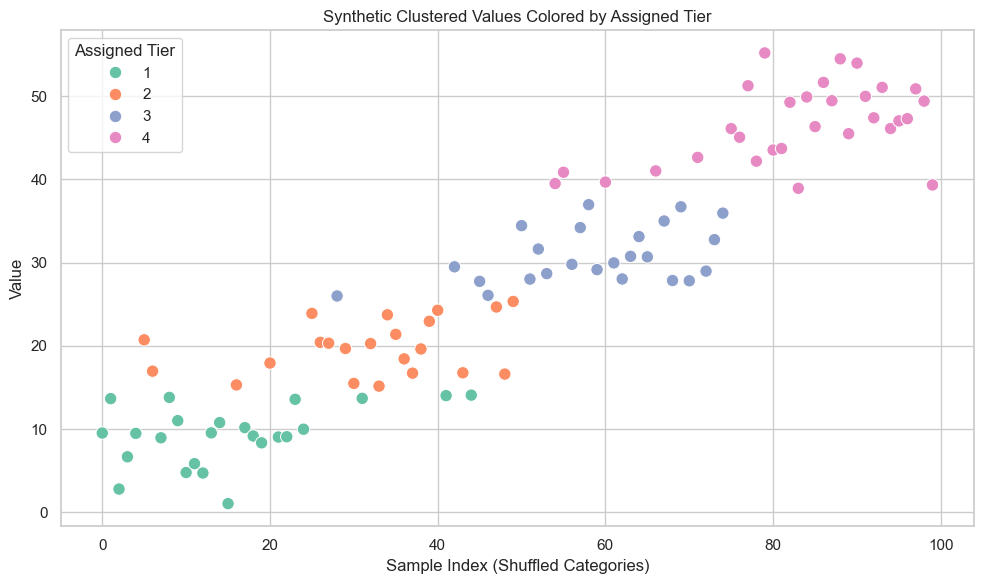

In [80]:
# Step 1: Generate generic clustered data (no manager context)

np.random.seed(2025)

# Simulate 4 true clusters (tiers) with unique means
true_centers = [10, 20, 35, 50]
points_per_cluster = 25
records = []

for tier, center in enumerate(true_centers, 1):
    for i in range(points_per_cluster):
        val = np.random.normal(loc=center, scale=5)
        cat = f"Category_{tier}_{i}"
        records.append({"category": cat, "true_tier": tier, "value": val})

generic_df = pd.DataFrame(records)

# Step 2: Cluster using our tiering function
tiered_result = assign_category_tiers(
    generic_df, 
    group_col="category", 
    value_col="value", 
    method="kmeans", 
    n_tiers=4
)

# Merge back for plotting
generic_df = generic_df.merge(tiered_result, on="category")

# Step 3: Visualize clustering outcome
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=generic_df, 
    x=range(len(generic_df)), 
    y="value", 
    hue="tier", 
    palette="Set2", 
    s=80
)
plt.title("Synthetic Clustered Values Colored by Assigned Tier")
plt.xlabel("Sample Index (Shuffled Categories)")
plt.ylabel("Value")
plt.legend(title="Assigned Tier")
plt.tight_layout()
plt.show()


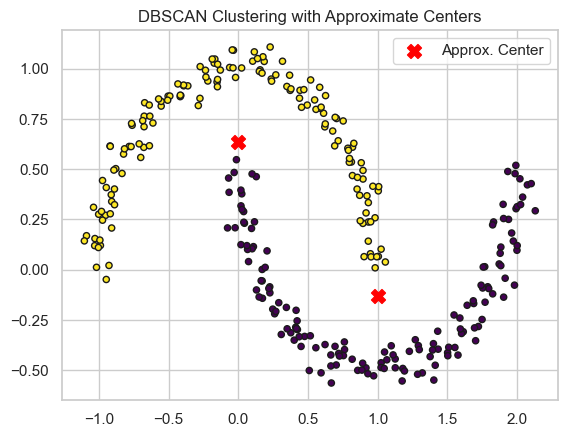

In [81]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Fit DBSCAN
db = DBSCAN(eps=0.2, min_samples=5).fit(X)
labels = db.labels_
core_sample_mask = np.zeros_like(labels, dtype=bool)
core_sample_mask[db.core_sample_indices_] = True

# Get core samples
core_points = X[core_sample_mask]
core_labels = labels[core_sample_mask]

# Approximate cluster centers (mean of core points per cluster)
cluster_centers = np.array([
    core_points[core_labels == k].mean(axis=0)
    for k in set(core_labels) if k != -1
])

# Plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=20, edgecolor='k')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='X', label='Approx. Center')
plt.legend()
plt.title('DBSCAN Clustering with Approximate Centers')
plt.show()


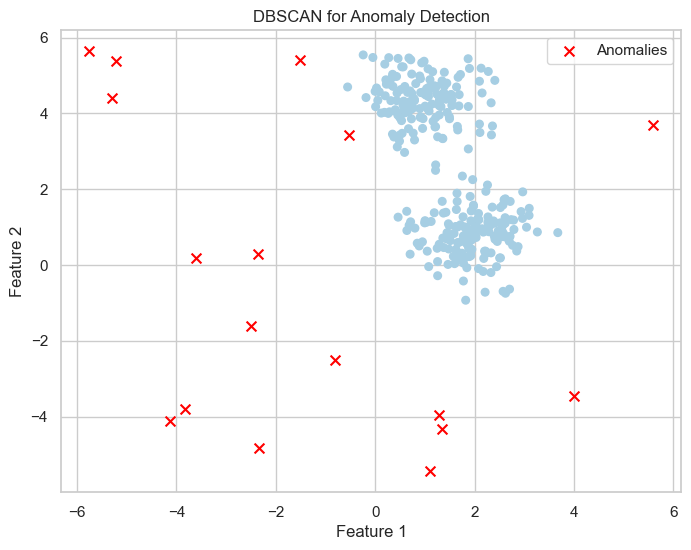

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

# Create clustered data with some scattered outliers
X, _ = make_blobs(n_samples=300, centers=2, cluster_std=0.6, random_state=0)

# Add random noise points (anomalies)
rng = np.random.RandomState(42)
n_anomalies = 20
X_outliers = rng.uniform(low=-6, high=6, size=(n_anomalies, 2))
X_total = np.vstack([X, X_outliers])

# Run DBSCAN
db = DBSCAN(eps=0.8, min_samples=5).fit(X_total)
labels = db.labels_

# Identify noise points
noise = X_total[labels == -1]
normal = X_total[labels != -1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c=labels[labels != -1], cmap='Paired', s=30)
plt.scatter(noise[:, 0], noise[:, 1], c='red', marker='x', s=50, label='Anomalies')
plt.legend()
plt.title("DBSCAN for Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
